In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import pickle
import io
import lmdb
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch
import matplotlib.pyplot as plt
import io
import lmdb
import pickle
import gc


In [344]:
smote_ima_dir = './output/gaf_images'
normal_img_dir = './output/normal/gaf_images'
undersampled_img_dir = './output/undersampled/gaf_images'
meta_data_drop_dataset = './output/final_dataset/gaf_images'

input_folder = './data'
output_folder = './output/final_dataset'
lmdb_path = os.path.join(output_folder, 'gaf_images')
pca_components = 32
os.makedirs(output_folder, exist_ok=True)


In [ ]:
# GAF Creation Function
def gaf_transform_torch(x, device='cpu'):
    min_x = x.min(dim=1, keepdim=True).values
    max_x = x.max(dim=1, keepdim=True).values
    scaled_x = (2 * (x - min_x) / (max_x - min_x + 1e-8)) - 1
    scaled_x = torch.clamp(scaled_x, -1, 1)
    phi = torch.arccos(scaled_x)
    gaf = torch.cos(phi.unsqueeze(2) + phi.unsqueeze(1))
    return gaf

In [346]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA:", torch.cuda.get_device_name(0))
elif getattr(torch.backends, 'mps', None) and torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple MPS (Metal Performance Shaders)")
else:
    device = torch.device('cpu')
    print("Using CPU")

Using Apple MPS (Metal Performance Shaders)


In [347]:

dos_attacks = ['DoS GoldenEye', 'DoS Hulk', 'DoS Slowhttptest', 'DoS slowloris']
brute_force_attacks = ['FTP-Patator', 'SSH-Patator']
web_attacks = ['Web Attack � Brute Force', 'Web Attack � Sql Injection', 'Web Attack � XSS']

def map_to_broader_category(label):
    if label == 'BENIGN':
        return 'BENIGN'
    elif label == 'DDoS':
        return 'DDoS'
    elif label == 'PortScan':
        return 'PortScan'
    elif label in dos_attacks:
        return 'DoS'
    elif label in brute_force_attacks:
        return 'BruteForce'
    elif label in web_attacks:
        return 'WebAttack'
    elif label == 'Bot':
        return 'Bot'
    elif label == 'Infiltration':
        return 'Infiltration'
    elif label == 'Heartbleed':
        return 'Heartbleed'
    else:
        return 'Other'


In [ ]:
checkpoint_folder = os.path.join(output_folder, 'checkpoints')
os.makedirs(checkpoint_folder, exist_ok=True)

map_size = 35 * 1024 ** 3  
print(f"LMDB map_size set to: {map_size / (1024**3):.0f} GB")

env = lmdb.open(lmdb_path, map_size=map_size)
csv_files = [f for f in os.listdir(input_folder) if f.endswith('.csv')]
scaler = StandardScaler()
pca = PCA(n_components=pca_components)

with env.begin(write=True) as txn:
    for csv_file in csv_files:
        # Check if CSV already done
        checkpoint_file = os.path.join(checkpoint_folder, csv_file + '.done')
        if os.path.exists(checkpoint_file):
            print(f"✅ Skipping {csv_file} (already processed, found checkpoint)")
            continue

        print(f"\n📄 Processing {csv_file}...")
        try:
            df_path = os.path.join(input_folder, csv_file)
            df = pd.read_csv(df_path)
            df.columns = df.columns.str.strip()
            if 'Label' not in df.columns:
                print(f"⚠ Skipping {csv_file} — 'Label' column not found.")
                continue

            df = df.replace([np.inf, -np.inf], np.nan).dropna()
            labels = df['Label'].values
            drop_cols = [
                'Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port',
                'Protocol', 'Timestamp', 'Label'
            ]
            feature_cols = [col for col in df.columns if col not in drop_cols]
            features = df.select_dtypes(include=[np.number])
            features = features.replace([np.inf, -np.inf], np.nan).dropna()
            X_res = features.values
            y_res = labels

            y_categorized = np.array([map_to_broader_category(label) for label in y_res])
            print(f"After category merging: {dict(zip(*np.unique(y_categorized, return_counts=True)))}")
            y_res = y_categorized

            features_scaled = scaler.fit_transform(X_res)
            features_reduced = pca.fit_transform(features_scaled)
            labels_res = y_res

            print(f"Generating GAF images and storing (label, data) in LMDB...")

            # ✅ BATCHED GAF PROCESSING TO PREVENT OOM
            batch_size = 1024
            for start_idx in range(0, len(features_reduced), batch_size):
                end_idx = min(start_idx + batch_size, len(features_reduced))
                batch_features = features_reduced[start_idx:end_idx]
                batch_labels = labels_res[start_idx:end_idx]

                try:
                    flows_torch = torch.tensor(batch_features, dtype=torch.float32, device=device)
                    gaf_images = gaf_transform_torch(flows_torch, device=device).cpu().numpy()

                    for idx, (gaf_image, label) in enumerate(zip(gaf_images, batch_labels)):
                        buf = io.BytesIO()
                        plt.imsave(buf, gaf_image, cmap='gray', format='png')
                        buf.seek(0)
                        image_bytes = buf.read()
                        buf.close()
                        key = f"{os.path.splitext(csv_file)[0]}_{start_idx + idx:07d}".encode('utf-8')
                        record = {"label": str(label), "data": image_bytes}
                        txn.put(key, pickle.dumps(record))
                except Exception as e:
                    print(f"⚠ Error on batch {start_idx}-{end_idx}: {e}")
                    continue

                torch.cuda.empty_cache()
                gc.collect()

            # === Write checkpoint file to mark as done ===
            with open(checkpoint_file, 'w') as f:
                f.write('done')
            print(f"Checkpoint saved: {checkpoint_file}")
        except Exception as e:
            print(f"❌ Error processing {csv_file}: {e}")
            continue

print("\n✅ GAF image generation and LMDB (label, data) storage complete.")

LMDB map_size set to: 35 GB

📄 Processing Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv...
After category merging: {'BENIGN': 288359, 'Infiltration': 36}
Generating GAF images and storing (label, data) in LMDB...
Checkpoint saved: ./output/final_dataset/checkpoints/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv.done

📄 Processing Monday-WorkingHours.pcap_ISCX.csv...
After category merging: {'BENIGN': 529481}
Generating GAF images and storing (label, data) in LMDB...
Checkpoint saved: ./output/final_dataset/checkpoints/Monday-WorkingHours.pcap_ISCX.csv.done

📄 Processing Friday-WorkingHours-Morning.pcap_ISCX.csv...
After category merging: {'BENIGN': 188955, 'Bot': 1956}
Generating GAF images and storing (label, data) in LMDB...
Checkpoint saved: ./output/final_dataset/checkpoints/Friday-WorkingHours-Morning.pcap_ISCX.csv.done

📄 Processing Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv...
After category merging: {'BENIGN': 127292, 'PortScan': 158804}
Gen

In [349]:
class LMDBGAFDataset(Dataset):
    def __init__(self, lmdb_path, transform=None):
        self.env = lmdb.open(lmdb_path, readonly=True, lock=False)
        self.txn = self.env.begin()
        self.keys = []
        self.labels = []
        self.transform = transform
        with self.env.begin() as txn:
            for key, value in txn.cursor():
                record = pickle.loads(value)
                label = record['label']
                self.keys.append(key)
                self.labels.append(label)
        
    
    def __len__(self):
        return len(self.keys)
    
    def __getitem__(self, idx):
        key = self.keys[idx]
        value = self.txn.get(key)
        record = pickle.loads(value)
        label = record['label']
        image = Image.open(io.BytesIO(record['data'])).convert('L')
        if self.transform:
            image = self.transform(image)
        return image, label

In [384]:
dataset = LMDBGAFDataset(meta_data_drop_dataset)

In [385]:
import matplotlib.pyplot as plt
import random

def show_images(images):
    """
    Sub plot the images in a grid.
    """
    plt.figure(figsize=(12, 12))
    for i, image in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.title(f'Label: {image[1]}')
        plt.imshow(image[0], cmap='gray')
        plt.axis('off')
    plt.show()

def analyse_dataset(dataset):
    """
    Analyze the dataset to get the distribution of labels.
    """
    label_counts = {}
    for _, label in dataset:
        if label not in label_counts:
            label_counts[label] = 0
        label_counts[label] += 1
    return label_counts


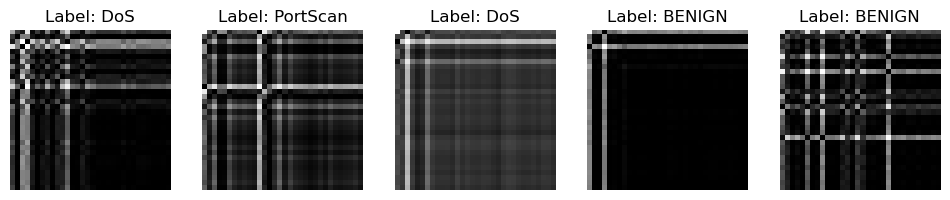

In [386]:
images = []
for i in range(5):
    images.append(dataset[random.randint(0, len(dataset) - 1)])
       
show_images(images)

In [387]:
dataset_analysis = analyse_dataset(dataset)

In [388]:
print("Dataset Analysis:", dataset_analysis)
unique_labels = set(dataset_analysis.keys())
print("Unique Labels in Dataset:", unique_labels)

Dataset Analysis: {'BENIGN': 2271320, 'DDoS': 128025, 'PortScan': 158804, 'Bot': 1956, 'Infiltration': 36, 'WebAttack': 2180, 'BruteForce': 13832, 'DoS': 251712, 'Heartbleed': 11}
Unique Labels in Dataset: {'WebAttack', 'PortScan', 'Heartbleed', 'BruteForce', 'DoS', 'DDoS', 'Bot', 'BENIGN', 'Infiltration'}


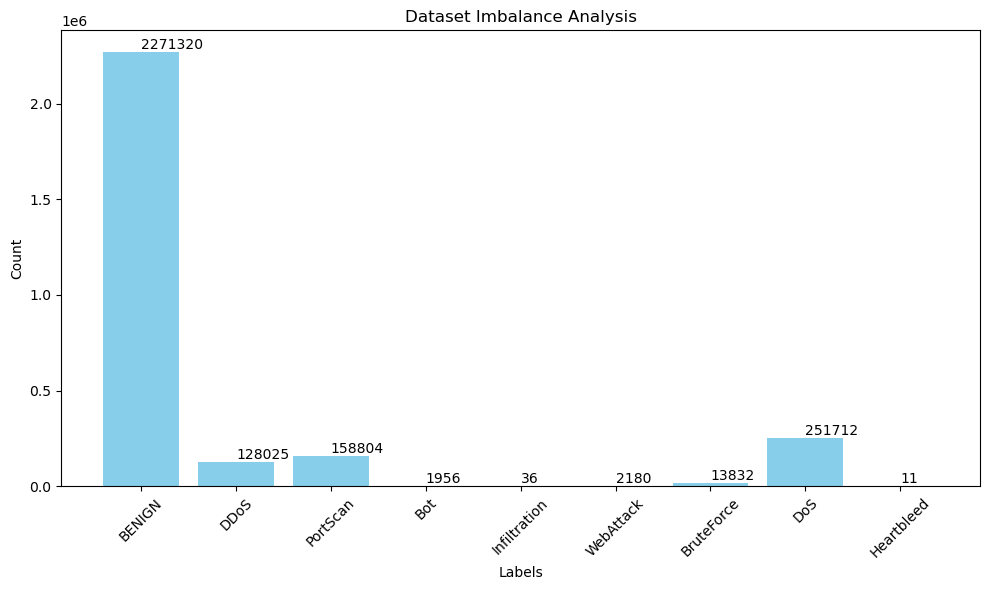

In [448]:
# Plot graph to show dataset imbalance with each bar value in it.
plt.figure(figsize=(10, 6))
bars = plt.bar(dataset_analysis.keys(), dataset_analysis.values(), color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Dataset Imbalance Analysis')
plt.xticks(rotation=45)
plt.tight_layout()

# Add data labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom')  # va: vertical alignment

plt.show()

In [392]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=9):
        super(SimpleCNN, self).__init__()
        # Input: (batch, 1, 32, 32)
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # (batch, 16, 32, 32)
        self.pool1 = nn.MaxPool2d(2, 2)                         # (batch, 16, 16, 16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # (batch, 32, 16, 16)
        self.pool2 = nn.MaxPool2d(2, 2)                         # (batch, 32, 8, 8)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # (batch, 64, 8, 8)
        self.pool3 = nn.MaxPool2d(2, 2)                         # (batch, 64, 4, 4)
        self.fc1 = nn.Linear(64*4*4, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [393]:
def get_labels_indices(dataset):
    
    all_indices = list(range(len(dataset)))
    all_labels = []
    for idx in all_indices:
        _, label = dataset[idx]
        all_labels.append(label)
    
    return all_labels, all_indices



In [394]:
all_labels, all_indices = get_labels_indices(dataset)

label_to_idx = {label: idx for idx, label in enumerate(unique_labels)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

print("Label mapping:", label_to_idx)

from sklearn.model_selection import train_test_split

# Split into train (70%) and temp (30%)
train_keys, temp_keys, train_labels, temp_labels = train_test_split(
    all_indices, all_labels, test_size=0.3, stratify=all_labels, random_state=42
)

# Split temp into validation (15%) and test (15%)
val_keys, test_keys, val_labels, test_labels = train_test_split(
    temp_keys, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

train_labels_encoded = [label_to_idx[label] for label in train_labels]
val_labels_encoded = [label_to_idx[label] for label in val_labels]
test_labels_encoded = [label_to_idx[label] for label in test_labels]

Label mapping: {'WebAttack': 0, 'PortScan': 1, 'Heartbleed': 2, 'BruteForce': 3, 'DoS': 4, 'DDoS': 5, 'Bot': 6, 'BENIGN': 7, 'Infiltration': 8}


In [396]:
import torchvision.transforms as T

transform = T.Compose([
    T.ToTensor(),   
])

class TransformDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        if self.transform:
            x = self.transform(x)
            y = label_to_idx[y] 
        return x, y

train_dataset = torch.utils.data.Subset(
    dataset,
    train_keys
)

val_dataset = torch.utils.data.Subset(
    dataset,
    val_keys
)

test_dataset = torch.utils.data.Subset(
    dataset,
    test_keys,
)
# Create transformed datasets
transformed_train_subset = TransformDataset(train_dataset, transform)
transformed_val_subset = TransformDataset(val_dataset, transform)
transformed_test_subset = TransformDataset(test_dataset, transform)


train_dataloader = torch.utils.data.DataLoader(
    transformed_train_subset,
    batch_size=64,
    shuffle=True,
    num_workers=0
)
val_dataloader = torch.utils.data.DataLoader(
    transformed_val_subset,
    batch_size=64,
    shuffle=False,
    num_workers=0
)
test_dataloader = torch.utils.data.DataLoader(
    transformed_test_subset,
    batch_size=64,
    shuffle=False,
    num_workers=0
)

In [398]:
def train_model_verbose(model, train_dataloader, val_dataloader, num_epochs=5, learning_rate=0.001):
    from torch.optim import Adam

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_dataloader):
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if (i + 1) % 500 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}')

        avg_train_loss = running_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Train Loss: {avg_train_loss:.4f}')

        # Validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_dataloader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}')

    # Plot learning curve
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Learning Curve')
    plt.legend()
    plt.show()

    # Model analysis: check for overfitting
    if val_losses[-1] > train_losses[-1]:
        print("Warning: Possible overfitting detected (validation loss > training loss).")
    else:
        print("No overfitting detected (validation loss <= training loss).")

    return model

Epoch [1/5], Step [500/30930], Loss: 0.0855
Epoch [1/5], Step [1000/30930], Loss: 0.0127
Epoch [1/5], Step [1500/30930], Loss: 0.0796
Epoch [1/5], Step [2000/30930], Loss: 0.1213
Epoch [1/5], Step [2500/30930], Loss: 0.0416
Epoch [1/5], Step [3000/30930], Loss: 0.1310
Epoch [1/5], Step [3500/30930], Loss: 0.2922
Epoch [1/5], Step [4000/30930], Loss: 0.0059
Epoch [1/5], Step [4500/30930], Loss: 0.0013
Epoch [1/5], Step [5000/30930], Loss: 0.0246
Epoch [1/5], Step [5500/30930], Loss: 0.0036
Epoch [1/5], Step [6000/30930], Loss: 0.0068
Epoch [1/5], Step [6500/30930], Loss: 0.1072
Epoch [1/5], Step [7000/30930], Loss: 0.0193
Epoch [1/5], Step [7500/30930], Loss: 0.0034
Epoch [1/5], Step [8000/30930], Loss: 0.0142
Epoch [1/5], Step [8500/30930], Loss: 0.0082
Epoch [1/5], Step [9000/30930], Loss: 0.0175
Epoch [1/5], Step [9500/30930], Loss: 0.0017
Epoch [1/5], Step [10000/30930], Loss: 0.0085
Epoch [1/5], Step [10500/30930], Loss: 0.0165
Epoch [1/5], Step [11000/30930], Loss: 0.0329
Epoch [1

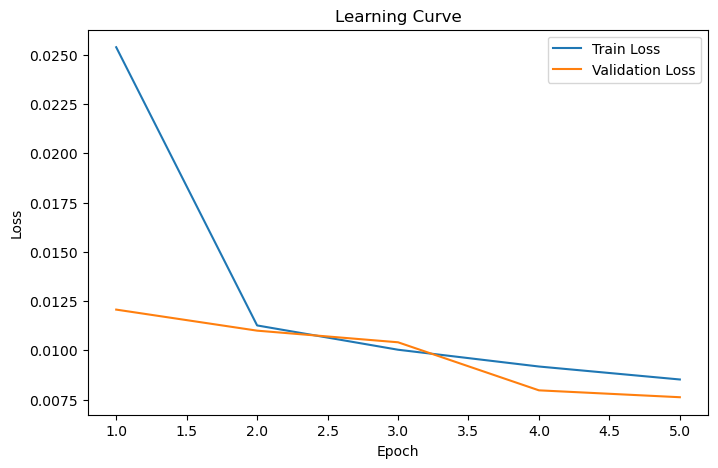

No overfitting detected (validation loss <= training loss).


SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
)

In [399]:
model = SimpleCNN(num_classes=9).to(device)
train_model_verbose(model, train_dataloader, val_dataloader, num_epochs=5,  learning_rate=0.001)

In [451]:
# test the model on test dataset and calculate accuracy and plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
def test_model(model, test_dataloader, model_name='model'):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in test_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the test dataset: {accuracy:.2f}%')

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_to_idx.keys(), yticklabels=label_to_idx.keys())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix ' + model_name)
    plt.show()

    return accuracy, all_labels, all_predictions

# accuracy, all_labels, all_predictions = test_model(model, test_dataloader)



In [401]:
# print the f1-score, precision, recall and accuracy
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_predictions, target_names=label_to_idx.keys()))

              precision    recall  f1-score   support

   WebAttack       0.77      0.95      0.85       327
    PortScan       1.00      1.00      1.00     23821
  Heartbleed       1.00      1.00      1.00         1
  BruteForce       0.98      0.99      0.98      2075
         DoS       0.99      1.00      0.99     37757
        DDoS       1.00      1.00      1.00     19204
         Bot       0.97      0.64      0.77       294
      BENIGN       1.00      1.00      1.00    340698
Infiltration       0.00      0.00      0.00         5

    accuracy                           1.00    424182
   macro avg       0.86      0.84      0.84    424182
weighted avg       1.00      1.00      1.00    424182



/Users/anmol/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anmol/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anmol/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Accuracy of the model on the test dataset: 99.81%


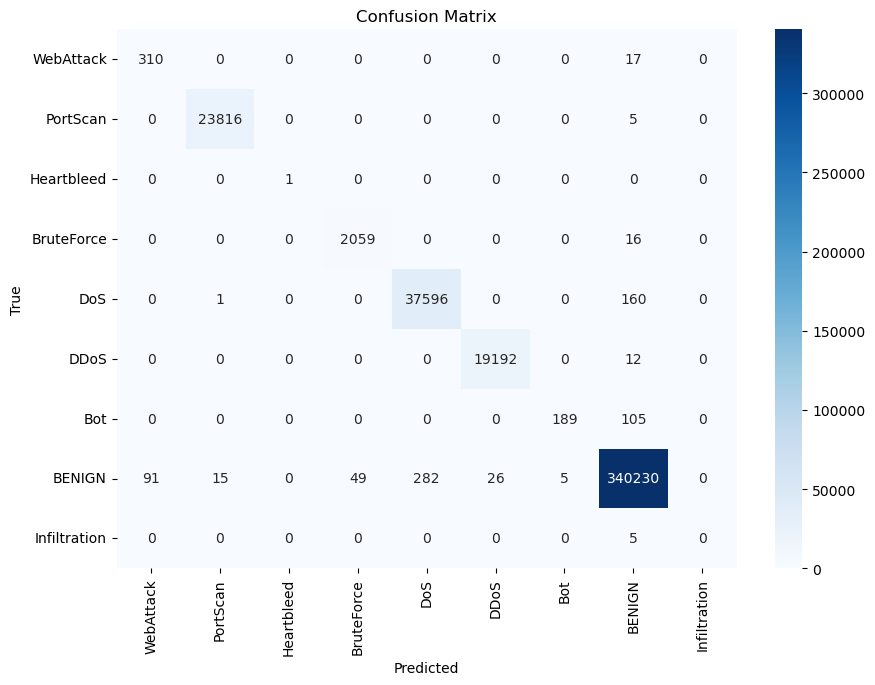

/Users/anmol/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1 Score: 99.8122
Precision: 99.8165
Recall: 99.8140
Accuracy: 99.8140
ROC AUC: 0.9975


In [443]:
accuracy, all_labels, all_predictions = test_model(model, test_dataloader)
# simplecnn f1 score, precision, recall and accuracy, ROC_AUC
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
# Binarize the labels for ROC AUC calculation
binarized_labels = label_binarize(all_labels, classes=list(label_to_idx.values()))
binarized_predictions = label_binarize(all_predictions, classes=list(label_to_idx.values()))
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
accuracy = accuracy_score(all_labels, all_predictions)
ROC_AUC = roc_auc_score(binarized_labels, binarized_predictions, average='weighted', multi_class='ovr')

print(f"F1 Score: {f1*100:.4f}")
print(f"Precision: {precision*100:.4f}")
print(f"Recall: {recall*100:.4f}")
print(f"Accuracy: {accuracy*100:.4f}")
print(f"ROC AUC: {ROC_AUC:.4f}")

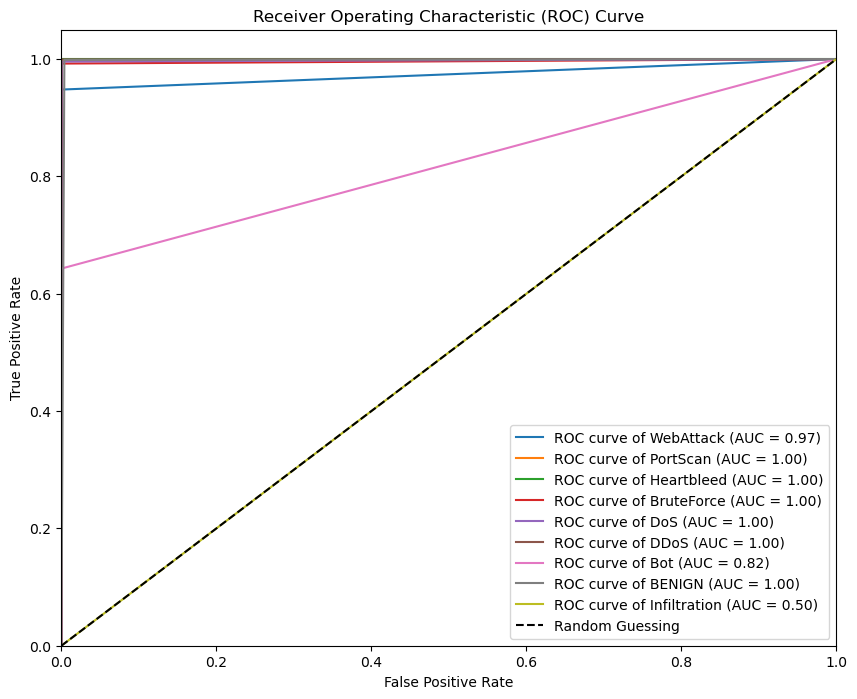

In [416]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Use sorted label indices to ensure correct order
class_names = [idx_to_label[i] for i in range(len(label_to_idx))]
y_test_bin = label_binarize(all_labels, classes=list(range(len(label_to_idx))))
n_classes = len(label_to_idx)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], np.array(all_predictions) == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of {class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [417]:
benign_idx = []
malicious_idx = []
for idx, data in enumerate(train_dataset):
    if data[1] == 'BENIGN':
        benign_idx.append(idx)
    else:
        malicious_idx.append(idx)

import random
sample_size = 250_000  # Or similar to DoS/DDoS/PortScan counts
benign_sampled = random.sample(benign_idx, sample_size)
final_indices = benign_sampled + malicious_idx


In [418]:
undersampled_train_dataset = torch.utils.data.Subset(
    train_dataset,
    final_indices
)
transformed_undersampled_train_dataset = TransformDataset(undersampled_train_dataset, transform)
undersampled_train_dataloader = torch.utils.data.DataLoader(
    transformed_undersampled_train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=0
)

Epoch [1/5], Step [500/9994], Loss: 0.1165
Epoch [1/5], Step [1000/9994], Loss: 0.1262
Epoch [1/5], Step [1500/9994], Loss: 0.0161
Epoch [1/5], Step [2000/9994], Loss: 0.0291
Epoch [1/5], Step [2500/9994], Loss: 0.2184
Epoch [1/5], Step [3000/9994], Loss: 0.1115
Epoch [1/5], Step [3500/9994], Loss: 0.0941
Epoch [1/5], Step [4000/9994], Loss: 0.0020
Epoch [1/5], Step [4500/9994], Loss: 0.0760
Epoch [1/5], Step [5000/9994], Loss: 0.0061
Epoch [1/5], Step [5500/9994], Loss: 0.0098
Epoch [1/5], Step [6000/9994], Loss: 0.0064
Epoch [1/5], Step [6500/9994], Loss: 0.0019
Epoch [1/5], Step [7000/9994], Loss: 0.0351
Epoch [1/5], Step [7500/9994], Loss: 0.0685
Epoch [1/5], Step [8000/9994], Loss: 0.0384
Epoch [1/5], Step [8500/9994], Loss: 0.0121
Epoch [1/5], Step [9000/9994], Loss: 0.2027
Epoch [1/5], Step [9500/9994], Loss: 0.0205
Epoch [1/5], Average Train Loss: 0.0611
Epoch [1/5], Validation Loss: 0.0251
Epoch [2/5], Step [500/9994], Loss: 0.0033
Epoch [2/5], Step [1000/9994], Loss: 0.0011
E

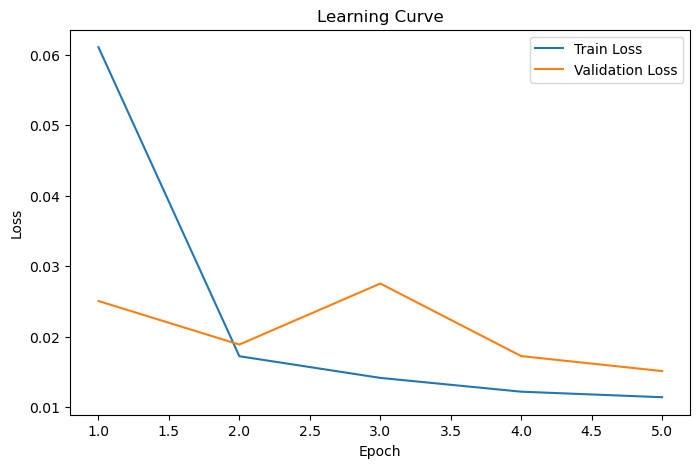

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=9, bias=True)
)

In [419]:
undersample_model = SimpleCNN(num_classes=9).to(device)
train_model_verbose(undersample_model, undersampled_train_dataloader, val_dataloader, num_epochs=5, learning_rate=0.001)

In [428]:
# use resnet18 for training
from torchvision import models

resnet18_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
resnet18_model.fc = nn.Linear(resnet18_model.fc.in_features, len(label_to_idx))
resnet18_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

resnet18_model = resnet18_model.to(device)

Epoch [1/5], Step [500/30930], Loss: 0.0575
Epoch [1/5], Step [1000/30930], Loss: 0.0497
Epoch [1/5], Step [1500/30930], Loss: 0.0059
Epoch [1/5], Step [2000/30930], Loss: 0.0102
Epoch [1/5], Step [2500/30930], Loss: 0.0501
Epoch [1/5], Step [3000/30930], Loss: 0.0099
Epoch [1/5], Step [3500/30930], Loss: 0.0032
Epoch [1/5], Step [4000/30930], Loss: 0.0144
Epoch [1/5], Step [4500/30930], Loss: 0.0357
Epoch [1/5], Step [5000/30930], Loss: 0.0375
Epoch [1/5], Step [5500/30930], Loss: 0.0059
Epoch [1/5], Step [6000/30930], Loss: 0.0853
Epoch [1/5], Step [6500/30930], Loss: 0.0078
Epoch [1/5], Step [7000/30930], Loss: 0.0411
Epoch [1/5], Step [7500/30930], Loss: 0.0644
Epoch [1/5], Step [8000/30930], Loss: 0.0114
Epoch [1/5], Step [8500/30930], Loss: 0.1006
Epoch [1/5], Step [9000/30930], Loss: 0.0108
Epoch [1/5], Step [9500/30930], Loss: 0.0167
Epoch [1/5], Step [10000/30930], Loss: 0.0141
Epoch [1/5], Step [10500/30930], Loss: 0.0149
Epoch [1/5], Step [11000/30930], Loss: 0.0075
Epoch [1

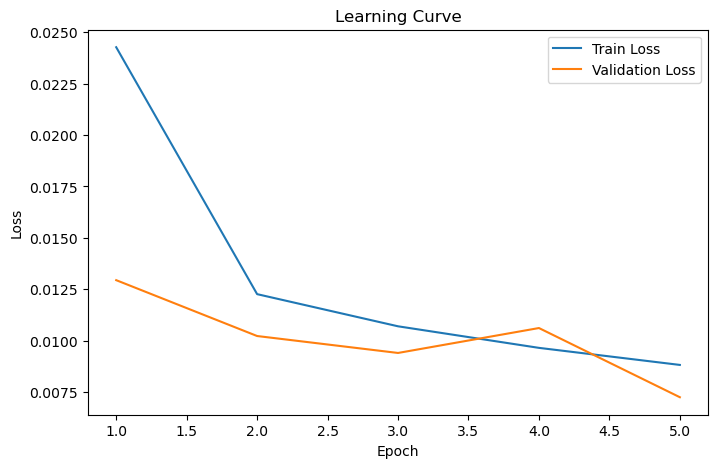

No overfitting detected (validation loss <= training loss).


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [429]:
train_model_verbose(resnet18_model, train_dataloader, val_dataloader, num_epochs=5, learning_rate=0.001)

Accuracy of the model on the test dataset: 99.77%


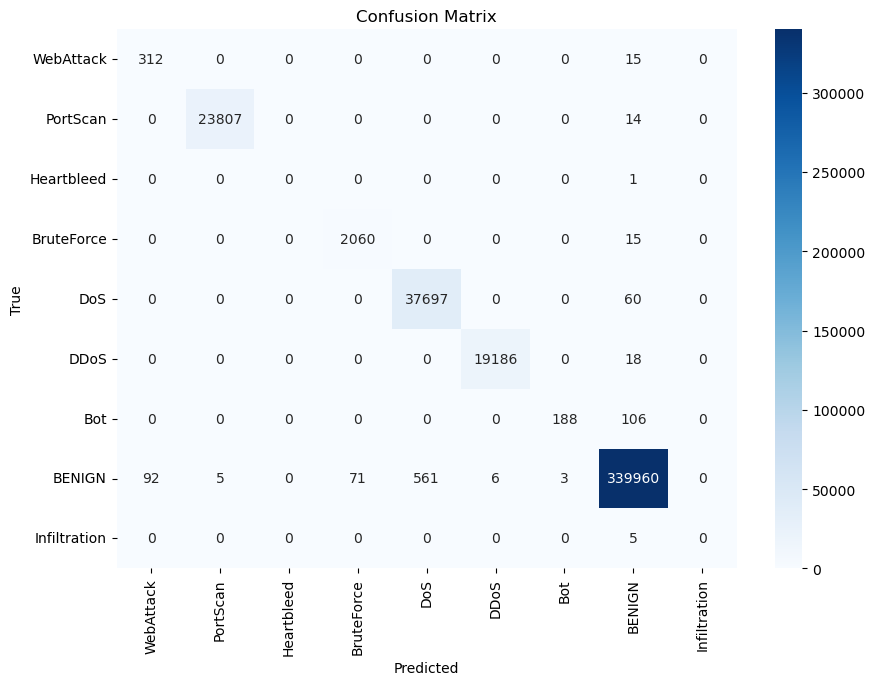

In [ ]:
accuracy, all_labels, all_predictions = test_model(resnet18_model, test_dataloader)

# Calculate confusion matrix
confusion_mat = confusion_matrix(all_labels, all_predictions)

In [ ]:
confusion_matrix

In [431]:
classification_report = classification_report(all_labels, all_predictions, target_names=label_to_idx.keys())
print(classification_report)

              precision    recall  f1-score   support

   WebAttack       0.77      0.95      0.85       327
    PortScan       1.00      1.00      1.00     23821
  Heartbleed       0.00      0.00      0.00         1
  BruteForce       0.97      0.99      0.98      2075
         DoS       0.99      1.00      0.99     37757
        DDoS       1.00      1.00      1.00     19204
         Bot       0.98      0.64      0.78       294
      BENIGN       1.00      1.00      1.00    340698
Infiltration       0.00      0.00      0.00         5

    accuracy                           1.00    424182
   macro avg       0.75      0.73      0.73    424182
weighted avg       1.00      1.00      1.00    424182



/Users/anmol/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anmol/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anmol/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [442]:
# resnet18 f1 score, precision, recall and accuracy, ROC_AUC
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
accuracy = accuracy_score(all_labels, all_predictions)
ROC_AUC = roc_auc_score(binarized_labels, binarized_predictions, average='weighted', multi_class='ovr')
print(f"F1 Score: {f1*100:.4f}")
print(f"Precision: {precision*100:.4f}")
print(f"Recall: {recall*100:.4f}")
print(f"Accuracy: {accuracy*100:.4f}")
print(f"ROC AUC: {ROC_AUC:.4f}")

/Users/anmol/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1 Score: 99.7693
Precision: 99.7753
Recall: 99.7709
Accuracy: 99.7709
ROC AUC: 0.9977


In [432]:
# save resnet18_model weight and simple cnn model weight
torch.save(resnet18_model.state_dict(), os.path.join(checkpoint_folder, 'resnet18_model.pth'))
torch.save(model.state_dict(), os.path.join(checkpoint_folder, 'simple_cnn_model.pth'))

Generating advanced metrics for ResNet18...


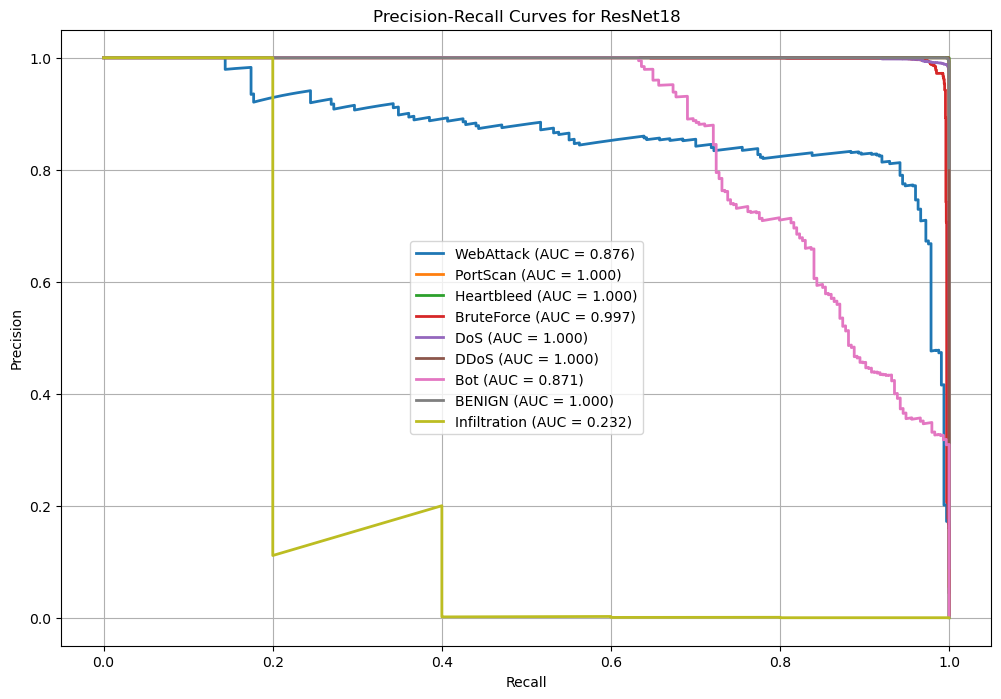

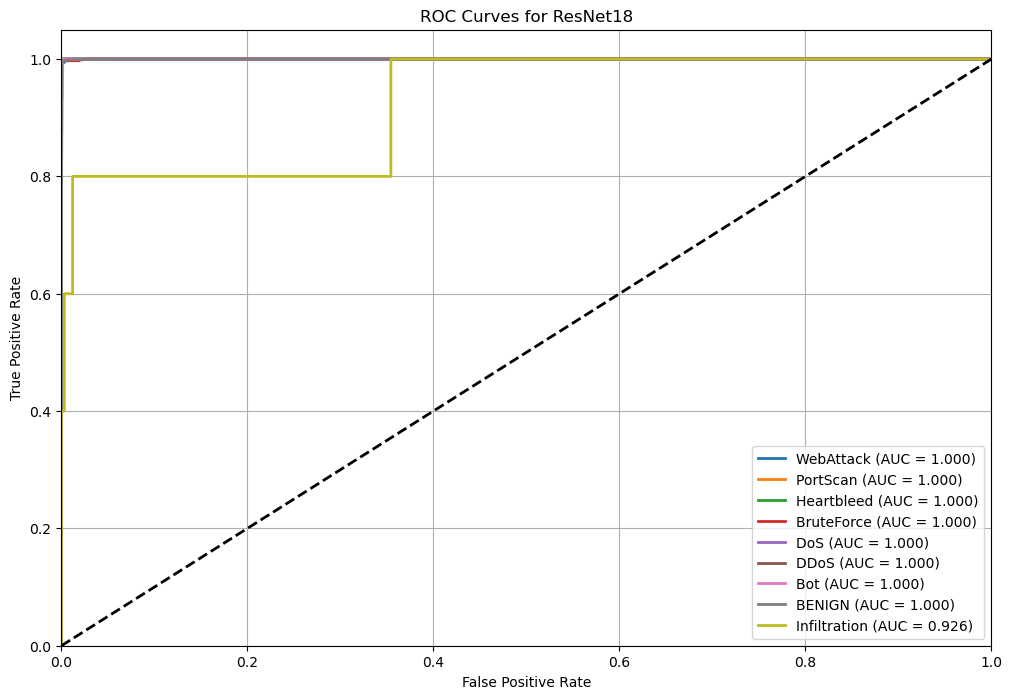

In [446]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# Advanced metrics visualization
def plot_precision_recall_curves(y_true, y_pred_proba, classes, model_name='Model'):
    '''Plot precision-recall curve for each class'''
    plt.figure(figsize=(12, 8))
    
    # For each class
    for i, cls in enumerate(classes):
        # Binarize the output
        y_true_bin = (y_true == i).astype(int)
        
        # Get prediction probability for this class
        y_pred_proba_cls = y_pred_proba[:, i]
        
        # Calculate precision and recall
        precision, recall, _ = precision_recall_curve(y_true_bin, y_pred_proba_cls)
        
        # Calculate area under PR curve
        pr_auc = auc(recall, precision)
        
        # Plot PR curve
        plt.plot(recall, precision, lw=2, label=f'{cls} (AUC = {pr_auc:.3f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves for ' + model_name)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

def plot_roc_curves(y_true, y_pred_proba, classes, model_name='Model'):
    '''Plot ROC curve for each class'''
    plt.figure(figsize=(12, 8))
    
    # For each class
    for i, cls in enumerate(classes):
        # Binarize the output
        y_true_bin = (y_true == i).astype(int)
        
        # Get prediction probability for this class
        y_pred_proba_cls = y_pred_proba[:, i]
        
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_true_bin, y_pred_proba_cls)
        
        # Calculate area under ROC curve
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, lw=2, label=f'{cls} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for ' + model_name)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

print("Generating advanced metrics for ResNet18...")
resnet18_model.eval()
test_probs = []
test_labels = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        outputs = resnet18_model(inputs)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        test_probs.append(probs.cpu().numpy())
        test_labels.append(labels.numpy())

test_probs = np.concatenate(test_probs)
test_labels = np.concatenate(test_labels)

class_names = list(label_to_idx.keys())
plot_precision_recall_curves(test_labels, test_probs, class_names, model_name='ResNet18')
plot_roc_curves(test_labels, test_probs, class_names, model_name='ResNet18')

Generating advanced metrics for Simple CNN...


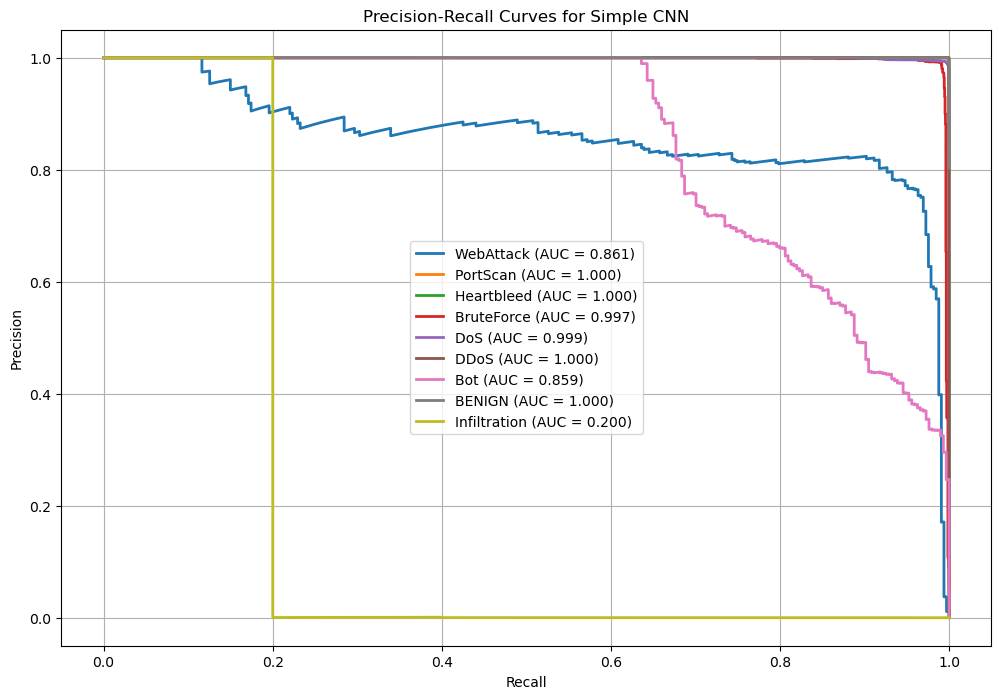

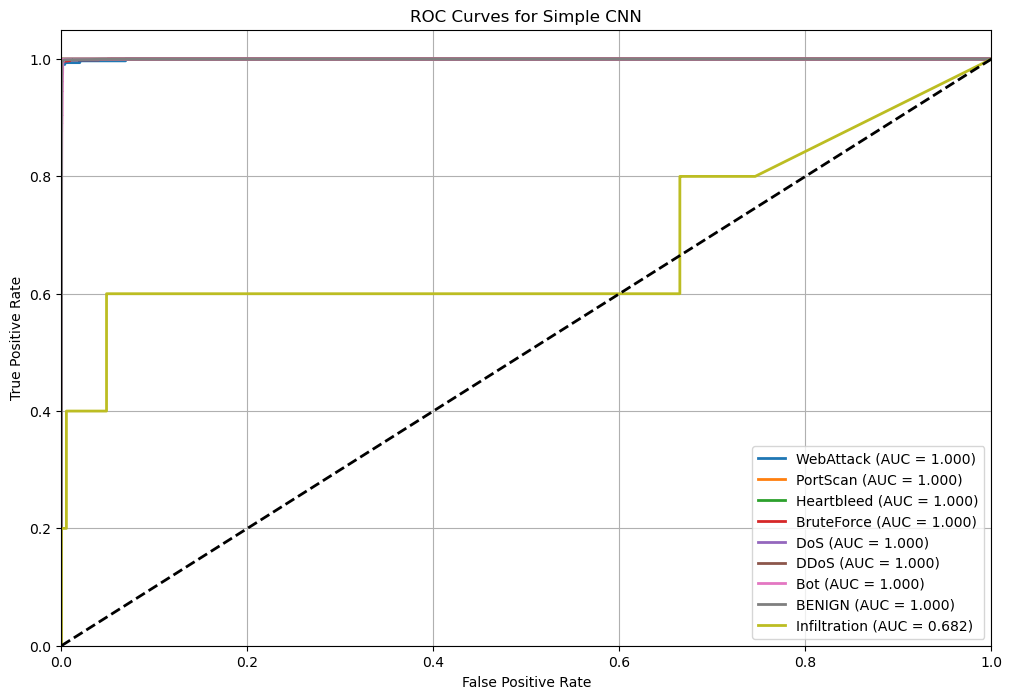

In [447]:
# plot roc and precision-recall curves for simple cnn model
print("Generating advanced metrics for Simple CNN...")
model.eval()
test_probs = []
test_labels = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        test_probs.append(probs.cpu().numpy())
        test_labels.append(labels.numpy())

test_probs = np.concatenate(test_probs)
test_labels = np.concatenate(test_labels)

class_names = list(label_to_idx.keys())
plot_precision_recall_curves(test_labels, test_probs, class_names, model_name='Simple CNN')
plot_roc_curves(test_labels, test_probs, class_names, model_name='Simple CNN')

Accuracy of the model on the test dataset: 99.81%


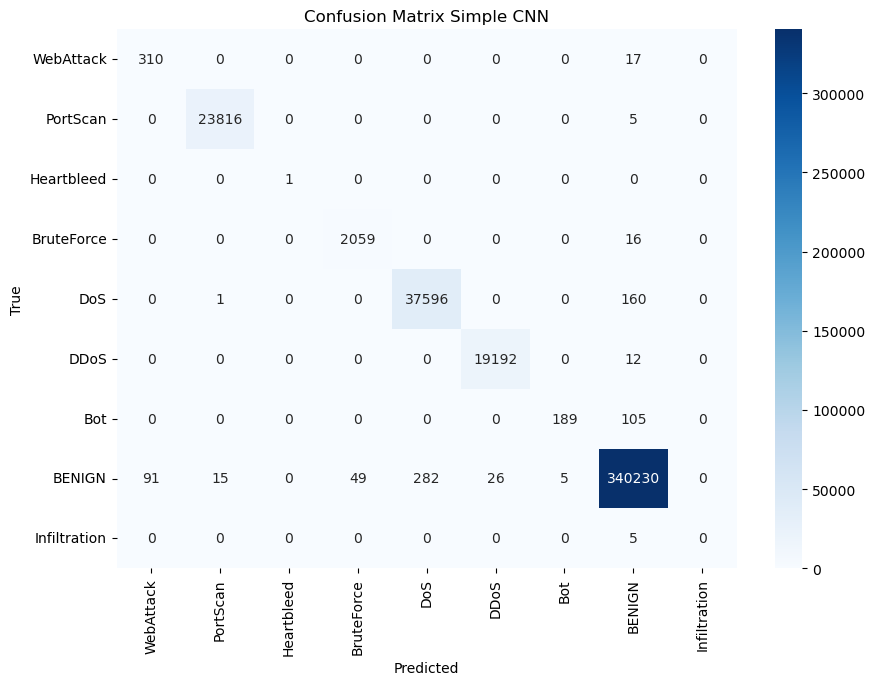

(99.8139949361359,
 [4,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  1,
  7,
  7,
  7,
  7,
  5,
  7,
  7,
  7,
  7,
  4,
  7,
  4,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  5,
  7,
  7,
  7,
  7,
  7,
  7,
  3,
  7,
  5,
  7,
  7,
  7,
  7,
  5,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  1,
  7,
  7,
  1,
  7,
  1,
  7,
  7,
  7,
  1,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  4,
  7,
  7,
  5,
  7,
  7,
  7,
  7,
  7,
  4,
  7,
  7,
  7,
  7,
  1,
  1,
  7,
  1,
  7,
  5,
  7,
  7,
  5,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  1,
  7,
  7,
  7,
  7,
  4,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  4,
  7,
  7,
  4,
  7,
  4,
  7,
  7,
  7,
  7,
  5,
  4,
  7,
  7,
  1,
  5,
  1,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  1,
  7,
  4,
  7,
  7,
  7,
  4,
  7,
  7,
  4,
  7,
  5,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
 

In [452]:
test_model(model, test_dataloader, model_name='Simple CNN')

Accuracy of the model on the test dataset: 99.77%


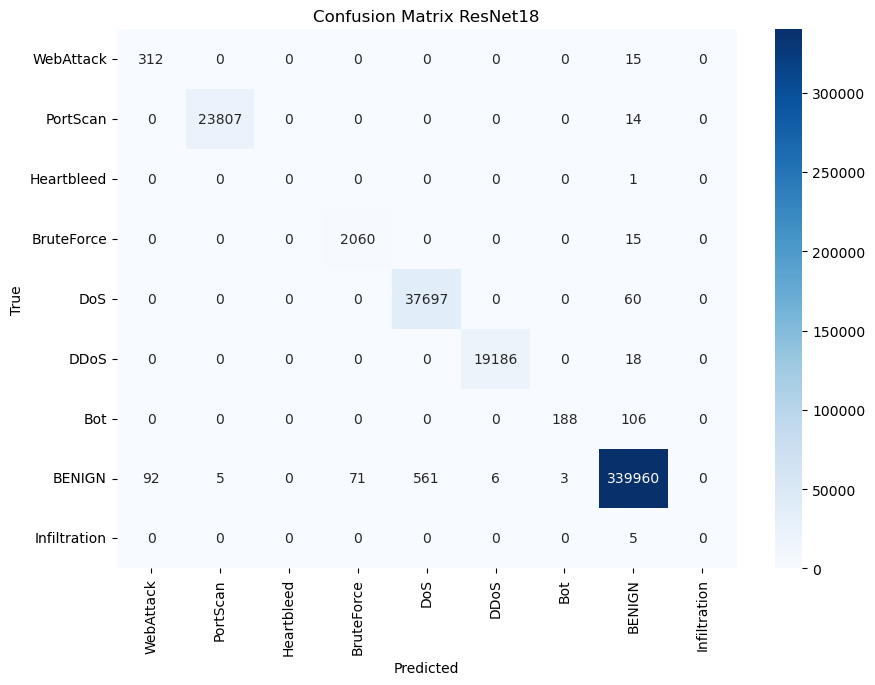

(99.77085307721686,
 [4,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  1,
  7,
  7,
  7,
  7,
  5,
  7,
  7,
  7,
  7,
  4,
  7,
  4,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  5,
  7,
  7,
  7,
  7,
  7,
  7,
  3,
  7,
  5,
  7,
  7,
  7,
  7,
  5,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  1,
  7,
  7,
  1,
  7,
  1,
  7,
  7,
  7,
  1,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  4,
  7,
  7,
  5,
  7,
  7,
  7,
  7,
  7,
  4,
  7,
  7,
  7,
  7,
  1,
  1,
  7,
  1,
  7,
  5,
  7,
  7,
  5,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  1,
  7,
  7,
  7,
  7,
  4,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  4,
  7,
  7,
  4,
  7,
  4,
  7,
  7,
  7,
  7,
  5,
  4,
  7,
  7,
  1,
  5,
  1,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  1,
  7,
  4,
  7,
  7,
  7,
  4,
  7,
  7,
  4,
  7,
  5,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,
  7,


In [453]:
test_model(resnet18_model, test_dataloader, model_name='ResNet18')